In [1]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# On importe la métrique "silhouette" qui nous servira à déterminer le nombre de clusters optimal.
from sklearn.metrics import silhouette_score 

%config InlineBackend.figure_format = 'png'

In [2]:
df = pd.read_csv('data/df_train.csv')

In [3]:
len(df)

1855314

In [4]:
# Recodage de certaines modalités afin de réordonner par ordre croissant d'engagement
df["contextid"] = df["contextid"].replace(0,1)
df["contextid"] = df["contextid"].replace(10,3)

# Remplacement des valeurs manquantes par des 0 dans les variables commençant par ltf
df['ltf_lastpartnerclicktimestamp'] = df['ltf_lastpartnerclicktimestamp'].fillna(0)
df['ltf_nbglobalclick_4w'] = df['ltf_nbglobalclick_4w'].fillna(0)
df['ltf_nbglobaldisplay_4w'] = df['ltf_nbglobaldisplay_4w'].fillna(0)
df['ltf_nbglobaldisplaysincelastpartnerproductview'] = df['ltf_nbglobaldisplaysincelastpartnerproductview'].fillna(0)
df['ltf_nbpartnerdisplayssincelastclick'] = df['ltf_nbpartnerdisplayssincelastclick'].fillna(0)
df['ltf_nbpartnerclick_4w'] = df['ltf_nbpartnerclick_4w'].fillna(0)
df['ltf_nbpartnerdisplay_4w'] = df['ltf_nbpartnerdisplay_4w'].fillna(0)
df['ltf_nbpartnersales_4w'] = df['ltf_nbpartnersales_4w'].fillna(0)
df['ltf_nbpartnerdisplay_90d'] = df['ltf_nbpartnerdisplay_90d'].fillna(0)
df['ltf_nbpartnerclick_90d'] = df['ltf_nbpartnerclick_90d'].fillna(0)
df['ltf_nbpartnersales_90d'] = df['ltf_nbpartnersales_90d'].fillna(0)
# Idem ici
df['nbdisplay_1hour'] = df['nbdisplay_1hour'].fillna(0)
df['nbdisplaypartnerapprox_1d_sum_xdevice'] = df['nbdisplaypartnerapprox_1d_sum_xdevice'].fillna(0)
df['nbdisplayaffiliateapprox_1d_sum_xdevice'] = df['nbdisplayaffiliateapprox_1d_sum_xdevice'].fillna(0)
df['nbdisplayglobalapprox_1d_sum_xdevice'] = df['nbdisplayglobalapprox_1d_sum_xdevice'].fillna(0)	
df['campaignctrlast24h'] = df['campaignctrlast24h'].fillna(0)

In [5]:
# Suppression de l'appareil cliquant un nombre aberrant de fois
df.drop(df.index[df['hashed_xd_id'] == r"b'\x12\xb97|\xbe~\\\x94\xe8\xa7\r\x9d#\x92\x95#\xd1J\xfa\x95G\x93\x13\x0f\x8a9Y\xc7\xb8I\xac\xa8'"], inplace = True)

In [6]:
df['display_size'] = df['display_width']*df['display_height']

In [7]:
# On enlève des variables ltf grâce aux corrélations visibles dans la matrice. 
df_clusters = df[['contextid','dayssincelastvisitdouble','campaignctrlast24h','nbdisplay_1hour','nbdayssincelastclick','display_size','ltf_nbpartnerdisplayssincelastclick','ltf_nbglobaldisplay_4w','ltf_nbpartnerclick_90d','ltf_nbpartnerdisplay_90d','ltf_nbpartnersales_90d','nbdisplayglobalapprox_1d_sum_xdevice']]

In [8]:
# On va chercher à obtenir des groupes d'observations de caractéristiques proches afin de voir si l'on peut distinguer les clics des non-clics. 
sc = StandardScaler()
Z = sc.fit_transform(df_clusters)
Z

array([[ 0.14873565, -0.40809959, -0.8906595 , ..., -0.07290974,
        -0.01397608, -0.32103262],
       [-1.92104218, -0.44867976, -0.360678  , ..., -0.07290974,
        -0.01397608,  0.8070464 ],
       [ 0.14873565, -0.33748309,  1.82717896, ..., -0.07290974,
        -0.01397608, -0.5009203 ],
       ...,
       [ 0.97664678, -0.36785013, -0.92834265, ..., -0.07290974,
        -0.01397608, -0.51352702],
       [ 1.39060235, -0.4168148 ,  2.20278178, ..., -0.07290974,
        -0.01397608, -0.34134216],
       [ 0.14873565, -0.1664472 , -0.50158415, ..., -0.07290974,
        -0.01397608, -0.45594838]])

In [9]:
# Vérification que les moyennes sont nulles et les écarts-types unitaires. 
print(np.mean(Z, axis=0))
print(np.std(Z, axis=0, ddof=0))

[-4.69520271e-17  2.45057639e-16 -5.90496082e-17 -2.05773590e-17
 -9.95337090e-18  1.23711223e-17  1.66154232e-17 -1.56712648e-17
  9.90263342e-18  4.87962244e-18 -2.46683444e-18 -3.14861388e-16]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [10]:
# On fixe une graine aléatoire pour avoir des résultats reproductibles
GRAINE = 146355806

In [11]:
# On applique la méthode des k-means sur les variables centrées et réduites, en supposant pour l'instant par défaut qu'il existe 2 clusters.
kmeans = KMeans(n_clusters=2, random_state=GRAINE) 
# random_state est la graine aléatoire specifiée pour rendre les résultats reproductibles.
kmeans.fit(Z)

# On trie les index en fonction des différents groupes de députés (ie des clusters).
idk = np.argsort(kmeans.labels_)

# Affichage des observations et de leurs groupes.
print(pd.DataFrame({"Observation" : df_clusters.index[idk], "Cluster" : kmeans.labels_[idk]}))

         Observation  Cluster
0                  0        0
1            1236366        0
2            1236364        0
3            1236363        0
4            1236362        0
...              ...      ...
1610489      1321770        1
1610490       327417        1
1610491      1441821        1
1610492       315064        1
1610493       959039        1

[1610494 rows x 2 columns]


In [12]:
nb_clusters = kmeans.labels_.tolist()
print(nb_clusters.count(0)) # Comptage du nombre de députés dans le cluster 1.
print(nb_clusters.count(1)) # Comptage du nombre de députés dans le cluster 2.

1604453
6041


Le découpage en deux clusters ne nous permettra pas de discriminer les clics des non-clics ; le deuxième cluster est en effet trop petit. 
Essayons avec 3 clusters. 

In [13]:
# Cellule dédiée au choix de la taille de l'échantillon du cluster sur lequel on va calculer le score de silhouette.
# On utilise également la graine GRAINE pour l'échantillonnage.
t0 = time.time()
silhouette_score(Z, kmeans.labels_, n_jobs=-1, sample_size=25000, random_state=GRAINE)
print(time.time() - t0)

11.80984115600586


In [14]:
# On va faire varier le nombre de clusters dans un intervalle réaliste, disons de 2 à 10.
taille_intervalle = 9
res = np.arange(taille_intervalle, dtype="double")
for k in np.arange(taille_intervalle):
    kmeans = KMeans(n_clusters=k+2, random_state=GRAINE)
    kmeans.fit(Z)
    res[k] = silhouette_score(Z, kmeans.labels_, n_jobs=-1, sample_size=25000, random_state=GRAINE)
    print(f"Nb clusters : {k+2} ; score silhouette : {res[k]}.")
# print(res)

Nb clusters : 2 ; score silhouette : 0.8680866579433779.
Nb clusters : 3 ; score silhouette : 0.27967020279514515.
Nb clusters : 4 ; score silhouette : 0.28801917294076956.
Nb clusters : 5 ; score silhouette : 0.17948918352077925.
Nb clusters : 6 ; score silhouette : 0.2042071150972515.
Nb clusters : 7 ; score silhouette : 0.23113030688396888.
Nb clusters : 8 ; score silhouette : 0.24975692412332298.
Nb clusters : 9 ; score silhouette : 0.2528961227548852.
Nb clusters : 10 ; score silhouette : 0.2623401903317868.


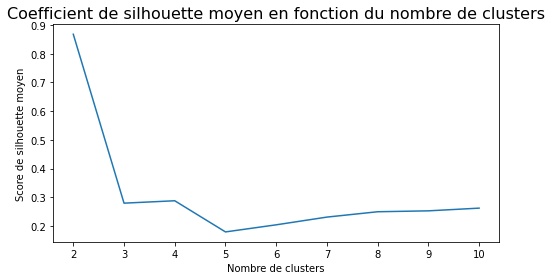

In [15]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(2,11,1), res)
plt.title("Coefficient de silhouette moyen en fonction du nombre de clusters", size=16)
plt.xlabel("Nombre de clusters", size=10)
plt.ylabel("Score de silhouette moyen", size=10)
plt.show()

In [16]:
kmeans = KMeans(n_clusters=4, random_state=GRAINE) 
kmeans.fit(Z)
idk = np.argsort(kmeans.labels_)
print(pd.DataFrame({"Observation" : df_clusters.index[idk], "Cluster" : kmeans.labels_[idk]}))

         Observation  Cluster
0                  0        0
1            1150550        0
2            1150549        0
3            1150548        0
4            1150547        0
...              ...      ...
1610489      1381862        3
1610490      1381860        3
1610491      1066547        3
1610492       359587        3
1610493       989620        3

[1610494 rows x 2 columns]


In [17]:
nb_clusters1 = kmeans.labels_.tolist()
print(nb_clusters1.count(0)) 
print(nb_clusters1.count(1))
print(nb_clusters1.count(2))
print(nb_clusters1.count(3))

1214530
6005
171724
218235


Etudions les caractéristiques des observations dans chacun des clusters. 

In [18]:
A = pd.DataFrame({"Observation" : df_clusters.index[idk], "Cluster" : kmeans.labels_[idk]})
L1 = [] # Liste qui contiendra les index des députés du cluster 1.
L2 = [] # Liste qui contiendra les index des députés du cluster 2.
L3 = [] # Liste qui contiendra les index des députés du cluster 3.
L4 = [] # Liste qui contiendra les index des députés du cluster 4.
for i in range(len(A)) :
    if A['Cluster'][i] == 0 :
        L1.append(A['Observation'][i])
    if A['Cluster'][i] == 1 :
        L2.append(A['Observation'][i])
    if A['Cluster'][i] == 2 : 
        L3.append(A['Observation'][i])
    if A['Cluster'][i] == 3 : 
        L4.append(A['Observation'][i])

In [19]:
df_cluster_1 = df.loc[L1] # Sous-table avec les députés du cluster 1.
df_cluster_2 = df.loc[L2] # Sous-table avec les députés du cluster 2.
df_cluster_3 = df.loc[L3] # Sous-table avec les députés du cluster 3.
df_cluster_4 = df.loc[L4] # Sous-table avec les députés du cluster 4.

In [20]:
len(L1), len(L2), len(L3), len(L4)

(1214530, 6005, 171724, 218235)

On retrouve bien le nombre d'observations présentes dans chaque cluster. 

In [21]:
# Répartition des clics et des non clics dans le cluster 1.
display(pd.DataFrame({'Nb dans cluster 1' : df_cluster_1['is_display_clicked'].value_counts(), 'Prop dans cluster 1' : df_cluster_1['is_display_clicked'].value_counts(normalize=True)})) 
# Répartition des clics et des non clics dans le cluster 2.
display(pd.DataFrame({'Nb dans cluster 2' : df_cluster_2['is_display_clicked'].value_counts(), 'Prop dans cluster 2' : df_cluster_2['is_display_clicked'].value_counts(normalize=True)})) 
# Répartition des clics et des non clics dans le cluster 3.
display(pd.DataFrame({'Nb dans cluster 3' : df_cluster_3['is_display_clicked'].value_counts(), 'Prop dans cluster 3' : df_cluster_3['is_display_clicked'].value_counts(normalize=True)}))
# Répartition des clics et des non clics dans le cluster 4.
display(pd.DataFrame({'Nb dans cluster 4' : df_cluster_4['is_display_clicked'].value_counts(), 'Prop dans cluster 4' : df_cluster_4['is_display_clicked'].value_counts(normalize=True)}))

,Nb dans cluster 1,Prop dans cluster 1
0,1137695,0.936737
1,76835,0.063263


,Nb dans cluster 2,Prop dans cluster 2
0,5561,0.926062
1,444,0.073938


,Nb dans cluster 3,Prop dans cluster 3
0,164902,0.960273
1,6822,0.039727


,Nb dans cluster 4,Prop dans cluster 4
0,210584,0.964941
1,7651,0.035059


In [22]:
df_cluster_1.describe()

,Unnamed: 0,contextid,target_env,rtbtypeid,rtbadvisibility,rtb_detectedlanguage,urlhash2,urlhash3,urlhash4,googleviewability,...,nbdisplaypartnerapprox_1d_sum_xdevice,nbdisplayaffiliateapprox_1d_sum_xdevice,nbdisplayglobalapprox_1d_sum_xdevice,valueperclick,display_width,display_height,display_timestamp,is_display_clicked,zonecostineuro,display_size
count,1.214530e+06,1.214530e+06,1.214530e+06,1.209507e+06,1.209507e+06,1.209507e+06,1.110091e+06,1.110091e+06,1.110091e+06,387349.000000,...,1.214530e+06,1.214530e+06,1.214530e+06,1.214530e+06,1.214530e+06,1.214530e+06,1.214530e+06,1.214530e+06,1.214530e+06,1.214530e+06
mean,9.293023e+05,5.477336e+00,1.112730e+00,3.659951e+01,7.285497e-01,9.446224e+01,9.839391e+07,-7.566101e+07,-1.107862e+08,59.306775,...,1.124536e+01,1.094701e+01,3.081458e+01,2.579208e-01,2.862949e+02,2.252042e+02,1.602857e+09,6.326316e-02,1.192573e+00,8.114627e+04
std,5.352814e+05,2.477548e+00,3.162626e-01,3.341509e+01,8.078666e-01,9.783166e+02,1.259963e+09,1.156586e+09,1.173206e+09,30.486496,...,1.428090e+01,2.099309e+01,3.532637e+01,1.845674e-01,2.497447e+02,2.281093e+02,1.745169e+05,2.434358e-01,3.145508e+00,9.764375e+04
min,0.000000e+00,1.000000e+00,1.000000e+00,3.000000e+00,0.000000e+00,-1.000000e+00,-2.147137e+09,-2.147454e+09,-2.147479e+09,-1.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,3.411759e-02,0.000000e+00,0.000000e+00,1.602547e+09,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.667155e+05,4.000000e+00,1.000000e+00,4.000000e+00,0.000000e+00,1.200000e+01,-9.654318e+08,-1.003142e+09,-1.022446e+09,37.000000,...,1.000000e+00,0.000000e+00,6.270266e+00,1.131779e-01,2.000000e+00,2.000000e+00,1.602700e+09,0.000000e+00,8.500000e-02,4.000000e+00
50%,9.285535e+05,6.000000e+00,1.000000e+00,2.900000e+01,1.000000e+00,1.600000e+01,2.603107e+08,-6.162982e+07,-2.862254e+08,66.000000,...,5.864144e+00,3.000000e+00,1.800000e+01,1.859788e-01,3.000000e+02,2.500000e+02,1.602855e+09,0.000000e+00,3.333878e-01,7.500000e+04
75%,1.392882e+06,7.000000e+00,1.000000e+00,7.300000e+01,1.000000e+00,1.270000e+02,1.384186e+09,8.233637e+08,7.813881e+08,85.000000,...,1.544028e+01,1.130546e+01,4.212188e+01,5.000993e-01,3.200000e+02,2.800000e+02,1.603021e+09,0.000000e+00,1.013000e+00,1.024000e+05
max,1.856872e+06,9.000000e+00,2.000000e+00,1.340000e+02,2.000000e+00,3.177000e+04,2.147366e+09,2.147451e+09,2.147451e+09,100.000000,...,1.890000e+02,3.036156e+02,2.505810e+02,7.905422e-01,1.374000e+03,1.286000e+03,1.603155e+09,1.000000e+00,1.000000e+02,1.101600e+06


In [23]:
df_cluster_2.describe()

,Unnamed: 0,contextid,target_env,rtbtypeid,rtbadvisibility,rtb_detectedlanguage,urlhash2,urlhash3,urlhash4,googleviewability,...,nbdisplaypartnerapprox_1d_sum_xdevice,nbdisplayaffiliateapprox_1d_sum_xdevice,nbdisplayglobalapprox_1d_sum_xdevice,valueperclick,display_width,display_height,display_timestamp,is_display_clicked,zonecostineuro,display_size
count,6.005000e+03,6005.000000,6005.000000,5988.000000,5988.000000,5988.000000,5.356000e+03,5.356000e+03,5.356000e+03,1855.000000,...,6005.000000,6005.000000,6005.000000,6005.000000,6005.000000,6005.000000,6.005000e+03,6005.000000,6005.000000,6.005000e+03
mean,9.216633e+05,7.374188,1.137552,34.011189,0.739813,69.330828,1.356797e+08,-9.248536e+07,-1.410151e+08,60.781132,...,25.198707,31.044927,82.745036,0.307009,327.961699,242.026978,1.602856e+09,0.073938,1.567122,8.853621e+04
std,5.385786e+05,1.842490,0.344458,32.846903,0.794863,563.200537,1.259821e+09,1.138648e+09,1.155639e+09,30.811736,...,21.056553,65.505627,99.869488,0.189287,266.523156,231.326105,1.767911e+05,0.261692,3.778073,9.751542e+04
min,9.400000e+01,1.000000,1.000000,3.000000,0.000000,1.000000,-2.140960e+09,-2.146561e+09,-2.146412e+09,-1.000000,...,0.000000,0.000000,0.000000,0.034118,0.000000,0.000000,1.602550e+09,0.000000,0.008475,0.000000e+00
25%,4.579450e+05,6.000000,1.000000,4.000000,0.000000,12.000000,-9.001059e+08,-1.006771e+09,-1.089605e+09,41.500000,...,6.979398,2.000000,28.000000,0.139050,160.000000,50.000000,1.602698e+09,0.000000,0.118646,1.600000e+04
50%,9.183840e+05,8.000000,1.000000,16.000000,1.000000,16.000000,3.640997e+08,-6.162982e+07,-2.701107e+08,68.000000,...,21.543889,10.179676,54.371852,0.245336,300.000000,250.000000,1.602850e+09,0.000000,0.470166,7.500000e+04
75%,1.390497e+06,9.000000,1.000000,73.000000,1.000000,127.000000,1.384186e+09,7.278802e+08,6.550648e+08,86.000000,...,41.000000,32.000000,98.489537,0.512843,336.000000,300.000000,1.603023e+09,0.000000,1.419046,1.536000e+05
max,1.856705e+06,9.000000,2.000000,134.000000,2.000000,30724.000000,2.141561e+09,2.146829e+09,2.144924e+09,99.000000,...,193.195278,1341.353333,1416.062778,0.790542,1280.000000,1280.000000,1.603149e+09,1.000000,84.459663,1.024000e+06


In [24]:
df_cluster_3.describe()

,Unnamed: 0,contextid,target_env,rtbtypeid,rtbadvisibility,rtb_detectedlanguage,urlhash2,urlhash3,urlhash4,googleviewability,...,nbdisplaypartnerapprox_1d_sum_xdevice,nbdisplayaffiliateapprox_1d_sum_xdevice,nbdisplayglobalapprox_1d_sum_xdevice,valueperclick,display_width,display_height,display_timestamp,is_display_clicked,zonecostineuro,display_size
count,1.717240e+05,171724.000000,171724.000000,171006.000000,171006.000000,171006.000000,1.545350e+05,1.545350e+05,1.545350e+05,53237.000000,...,171724.000000,171724.000000,171724.000000,171724.000000,171724.000000,171724.000000,1.717240e+05,171724.000000,171724.000000,1.717240e+05
mean,9.246655e+05,6.217273,1.089947,36.273692,0.717647,95.766312,9.122278e+07,-6.187909e+07,-1.034572e+08,58.497849,...,9.113251,12.982262,32.625727,0.224353,290.448342,219.232099,1.602858e+09,0.039727,0.739145,7.997536e+04
std,5.355911e+05,1.647041,0.286106,33.283918,0.810803,1015.665626,1.265114e+09,1.160608e+09,1.174688e+09,31.248834,...,12.553802,28.416230,44.880125,0.175795,255.211043,225.136794,1.755761e+05,0.195317,1.898668,9.725414e+04
min,1.000000e+01,1.000000,1.000000,3.000000,0.000000,-1.000000,-2.147479e+09,-2.147278e+09,-2.147319e+09,-1.000000,...,0.000000,0.000000,0.000000,0.034118,0.000000,0.000000,1.602547e+09,0.000000,0.000000,0.000000e+00
25%,4.595772e+05,6.000000,1.000000,4.000000,0.000000,12.000000,-1.015546e+09,-9.653825e+08,-1.009380e+09,34.000000,...,1.000000,0.000000,6.000000,0.087429,0.000000,0.000000,1.602700e+09,0.000000,0.051818,0.000000e+00
50%,9.220810e+05,6.000000,1.000000,29.000000,0.000000,16.000000,2.292188e+08,-6.162982e+07,-2.820157e+08,66.000000,...,4.000000,3.000000,16.559676,0.144372,300.000000,250.000000,1.602858e+09,0.000000,0.218000,7.500000e+04
75%,1.387374e+06,7.000000,1.000000,73.000000,1.000000,127.000000,1.384186e+09,8.401876e+08,7.830828e+08,85.000000,...,12.000000,12.000000,40.576736,0.299222,320.000000,280.000000,1.603023e+09,0.000000,0.661073,9.600000e+04
max,1.856869e+06,9.000000,2.000000,134.000000,2.000000,31770.000000,2.146981e+09,2.147417e+09,2.147359e+09,100.000000,...,174.481250,716.947917,734.793750,0.790542,1280.000000,1280.000000,1.603154e+09,1.000000,100.000000,1.024000e+06


In [25]:
df_cluster_4.describe()

,Unnamed: 0,contextid,target_env,rtbtypeid,rtbadvisibility,rtb_detectedlanguage,urlhash2,urlhash3,urlhash4,googleviewability,...,nbdisplaypartnerapprox_1d_sum_xdevice,nbdisplayaffiliateapprox_1d_sum_xdevice,nbdisplayglobalapprox_1d_sum_xdevice,valueperclick,display_width,display_height,display_timestamp,is_display_clicked,zonecostineuro,display_size
count,2.182350e+05,218235.000000,218235.000000,217082.00000,217082.000000,217082.000000,1.895640e+05,1.895640e+05,1.895640e+05,59216.000000,...,218235.000000,218235.000000,218235.000000,218235.000000,218235.000000,218235.000000,2.182350e+05,218235.000000,218235.000000,2.182350e+05
mean,9.321890e+05,6.048443,1.072756,37.08740,0.732064,94.816503,1.113809e+08,-1.778726e+08,-1.883800e+08,59.528759,...,35.948418,59.626699,128.330583,0.313647,363.708369,251.435228,1.602853e+09,0.035059,0.940507,9.208258e+04
std,5.374817e+05,2.453060,0.259737,33.75389,0.791542,1046.916814,1.215893e+09,1.124596e+09,1.153969e+09,34.500599,...,20.215833,89.078501,125.753298,0.189133,277.856972,234.957654,1.775439e+05,0.183928,2.544857,9.393635e+04
min,3.000000e+00,1.000000,1.000000,3.00000,0.000000,-1.000000,-2.145916e+09,-2.147307e+09,-2.147255e+09,-1.000000,...,0.000000,0.000000,13.000000,0.034118,0.000000,0.000000,1.602547e+09,0.000000,0.000000,0.000000e+00
25%,4.666530e+05,6.000000,1.000000,4.00000,0.000000,12.000000,-8.462803e+08,-1.089605e+09,-1.089605e+09,30.000000,...,22.000000,11.000000,47.987940,0.136647,300.000000,50.000000,1.602694e+09,0.000000,0.050000,1.600000e+04
50%,9.369130e+05,6.000000,1.000000,29.00000,1.000000,12.000000,3.640997e+08,-2.180814e+08,-5.237546e+08,68.000000,...,35.000000,28.414352,83.436574,0.269752,300.000000,250.000000,1.602849e+09,0.000000,0.258000,7.500000e+04
75%,1.397196e+06,8.000000,1.000000,73.00000,1.000000,127.000000,1.335917e+09,6.404254e+08,6.397927e+08,91.000000,...,49.023519,67.000000,169.923750,0.512843,360.000000,480.000000,1.603021e+09,0.000000,0.830579,1.800000e+05
max,1.856864e+06,9.000000,2.000000,134.00000,2.000000,31770.000000,2.146395e+09,2.147353e+09,2.147353e+09,100.000000,...,460.277870,2269.557407,3953.888889,0.790542,1280.000000,1286.000000,1.603152e+09,1.000000,100.000000,1.028800e+06
